In [36]:
import os
import json
import sys
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import ALDataModule_v1
from model.classifier_model import Classifier1DMaxPoolBNModel, Classifier1D
from utils.model_utils import unwrap_model

from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict


In [5]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument("-tl", "--train_limit_data", type=int, default=-1,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("-cn", "--class_num", type=int, default=6,
                    help=f"Number of class num use to train")

parser.add_argument("-m", "--model_name", type=str,
                    help=f"Config name of model used for training")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=["-m", "4cnnmp_128"])
else:
    args = parser.parse_args()

In [14]:
L.seed_everything(args.random_seed)

In [15]:
from lightning.pytorch.utilities.model_summary import ModelSummary

net = Classifier1DMaxPoolBNModel(
    **channel_param_dict[args.model_name],).to("cpu")

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes      | Out sizes    
--------------------------------------------------------------------------
0  | cnn      | Sequential  | 283 K  | [10, 6, 257]  | [10, 256, 1] 
1  | cnn.0    | Conv1d      | 1.8 K  | [10, 6, 257]  | [10, 32, 249]
2  | cnn.1    | MaxPool1d   | 0      | [10, 32, 249] | [10, 32, 83] 
3  | cnn.2    | BatchNorm1d | 64     | [10, 32, 83]  | [10, 32, 83] 
4  | cnn.3    | ReLU        | 0      | [10, 32, 83]  | [10, 32, 83] 
5  | cnn.4    | Conv1d      | 18.5 K | [10, 32, 83]  | [10, 64, 75] 
6  | cnn.5    | MaxPool1d   | 0      | [10, 64, 75]  | [10, 64, 25] 
7  | cnn.6    | BatchNorm1d | 128    | [10, 64, 25]  | [10, 64, 25] 
8  | cnn.7    | ReLU        | 0      | [10, 64, 25]  | [10, 64, 25] 
9  | cnn.8    | Conv1d      | 65.7 K | [10, 64, 25]  | [10, 128, 18]
10 | cnn.9    | MaxPool1d   | 0      | [10, 128, 18] | [10, 128, 6] 
11 | cnn.10   | BatchNorm1d | 256    | [10, 128, 6]  | [10, 128, 6] 
12 | cnn.11   | ReLU        

In [16]:
n_epochs = 20000
patience = n_epochs//100

batch_size = 512
optimizer, optimizer_param = optimizer_param_dict["Adam"]
dataset_path = f"dataset/processed_concat_data_{args.class_num}_labels"

log_save_dir = "lightning_logs"
log_save_name = f"10.1_classify/{args.model_name}-{args.class_num}-{args.train_limit_data}-{args.random_seed}"

In [ ]:
print(" ----------------------start training---------------------------")
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger

tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
checkpoint_callback = ModelCheckpoint(
    dirpath=None,
    save_top_k=1,
    monitor="val_loss",
    mode="min",
    filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
)

trainer = L.Trainer(
    logger=[tensorboard_logger, csv_logger],
    callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
    max_epochs=n_epochs,
    check_val_every_n_epoch=10,
    accelerator="gpu", 
    devices=4, 
    strategy="ddp"
    )

net = Classifier1DMaxPoolBNModel(
    optimizer = optimizer,
    optimizer_param = optimizer_param, 
    **channel_param_dict[args.model_name],
    out_class_num = args.class_num,
)

data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)

print("np.unique(data_module.train_label, return_counts=True)", np.unique(data_module.train_label, return_counts=True))

trainer.fit(model=net, datamodule=data_module)
trainer_test_dict = trainer.logged_metrics

trainer.test(model=net, datamodule=data_module)
trainer_test_dict.update(trainer.logged_metrics)

print("trainer.logger.log_dir", trainer.logger.log_dir)

for key in trainer_test_dict.keys():
    trainer_test_dict[key] = trainer_test_dict[key].item()

with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
    json.dump(trainer_test_dict, f, indent=4)

with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
    json.dump(args.__dict__, f, indent=4)

In [20]:
# checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/10.3_classify_8classes_10000data/version_4/checkpoints/sample_epoch=19639-step=78560-val_loss=0.385121.ckpt"

# data_module = ALDataModule_v1.load_from_checkpoint(checkpoint_path)
# data_module.set_normal_train()
# net = Classifier1D.load_from_checkpoint(checkpoint_path)

# trainer = L.Trainer()


# trainer.test(model=net, datamodule=data_module)
# output = trainer.predict(model=net, datamodule=data_module)
# pred = torch.argmax(torch.concat(output), dim=1)
# gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████| 16/16 [00:00<00:00, 130.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.848519504070282
        test_loss           0.4194597601890564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████| 16/16 [00:00<00:00, 186.93it/s]


Accuracy 0.8485195069259118
F1 0.8487649387471762
[[958   1   0   2   3   5   7  24]
 [ 20 960   0  12   0   3   2   3]
 [  3   6 858   2   0   0   0   0]
 [ 23   4   1 956   2   9   2   3]
 [ 36   0   0   0 933  21   3   7]
 [ 33   4   0   6  40 839  27  51]
 [207   1   0   4   9  20 552 207]
 [184   3   0   1  12  44 135 621]]


[Text(0.5, 23.52222222222222, 'Predict'),
 Text(50.722222222222214, 0.5, 'Ground truth'),
 [Text(0.5, 0, 'still'),
  Text(1.5, 0, 'walking'),
  Text(2.5, 0, 'run'),
  Text(3.5, 0, 'bike'),
  Text(4.5, 0, 'car'),
  Text(5.5, 0, 'bus'),
  Text(6.5, 0, 'train'),
  Text(7.5, 0, 'subway')],
 [Text(0, 0.5, 'still'),
  Text(0, 1.5, 'walking'),
  Text(0, 2.5, 'run'),
  Text(0, 3.5, 'bike'),
  Text(0, 4.5, 'car'),
  Text(0, 5.5, 'bus'),
  Text(0, 6.5, 'train'),
  Text(0, 7.5, 'subway')]]

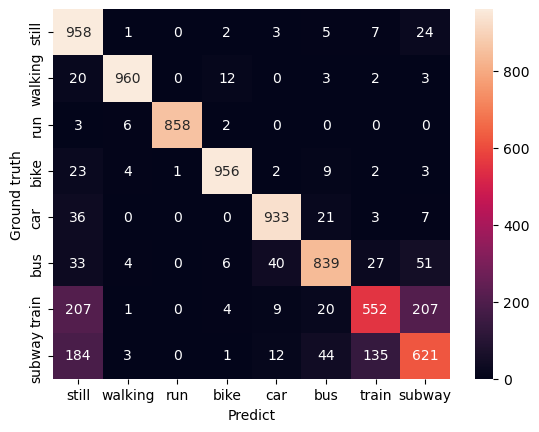

In [21]:
# pred_ravel = pred.numpy()
# gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))

# accuracy = accuracy_score(gt_ravel, pred_ravel)
# print("Accuracy", accuracy)

# f1 = f1=f1_score(gt_ravel, pred_ravel, average="macro")
# print("F1", f1)

# cf = confusion_matrix(gt_ravel, pred_ravel)

# print(cf)
# label_list = ["still", "walking", "run", "bike", "car", "bus", "train", "subway"]
# s = sns.heatmap(cf, annot=True, fmt='g')
# s.set(xlabel="Predict", ylabel="Ground truth", xticklabels=label_list, yticklabels=label_list)

In [61]:

if args.eval_mode:
    log_save_dir = "lightning_logs"
    log_save_name = "10.1_classify/{}-{}-{}-{}"
    
    result_save_dict = {}

    for args.model_name in "4cnnmp_128 4cnnmp_64 4cnn_128 4cnn_64 rich_128 rich_64".split(" "):
        args.class_num = 8
        for args.train_limit_data in "1000 5000".split(" "):
            for args.random_seed in "42 64".split():
                
                save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
                save_model_dir = os.path.join(log_save_dir, save_model_folder)
                
                weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
                print(save_model_folder, weight)

                net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)
                data_module = ALDataModule_v1.load_from_checkpoint(weight)
                data_module.set_normal_train()

                trainer = L.Trainer()
                trainer.test(model=net, datamodule=data_module, verbose=False)
                test_acc = trainer.logged_metrics["test_acc"]
                result_save_dict[save_model_folder] = test_acc


10.1_classify/4cnnmp_128-8-1000-42 lightning_logs/10.1_classify/4cnnmp_128-8-1000-42/version_0/checkpoints/sample_epoch=39-step=160-val_loss=0.944014.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 114.56it/s]
10.1_classify/4cnnmp_128-8-1000-64 lightning_logs/10.1_classify/4cnnmp_128-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.685367.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 104.71it/s]
10.1_classify/4cnnmp_128-8-5000-42 lightning_logs/10.1_classify/4cnnmp_128-8-5000-42/version_0/checkpoints/sample_epoch=59-step=1200-val_loss=0.890859.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 105.46it/s]
10.1_classify/4cnnmp_128-8-5000-64 lightning_logs/10.1_classify/4cnnmp_128-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.894188.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 110.70it/s]
10.1_classify/4cnnmp_64-8-1000-42 lightning_logs/10.1_classify/4cnnmp_64-8-1000-42/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.938964.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 115.05it/s]
10.1_classify/4cnnmp_64-8-1000-64 lightning_logs/10.1_classify/4cnnmp_64-8-1000-64/version_0/checkpoints/sample_epoch=29-step=120-val_loss=0.758986.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 103.04it/s]
10.1_classify/4cnnmp_64-8-5000-42 lightning_logs/10.1_classify/4cnnmp_64-8-5000-42/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.540751.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 111.20it/s]
10.1_classify/4cnnmp_64-8-5000-64 lightning_logs/10.1_classify/4cnnmp_64-8-5000-64/version_0/checkpoints/sample_epoch=39-step=800-val_loss=0.737125.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 105.47it/s]
10.1_classify/4cnn_128-8-1000-42 lightning_logs/10.1_classify/4cnn_128-8-1000-42/version_0/checkpoints/sample_epoch=109-step=440-val_loss=1.077022.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 104.96it/s]
10.1_classify/4cnn_128-8-1000-64 lightning_logs/10.1_classify/4cnn_128-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.522480.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 122.94it/s]
10.1_classify/4cnn_128-8-5000-42 lightning_logs/10.1_classify/4cnn_128-8-5000-42/version_0/checkpoints/sample_epoch=09-step=200-val_loss=0.674701.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 142.18it/s]
10.1_classify/4cnn_128-8-5000-64 lightning_logs/10.1_classify/4cnn_128-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.504091.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 123.31it/s]
10.1_classify/4cnn_64-8-1000-42 lightning_logs/10.1_classify/4cnn_64-8-1000-42/version_0/checkpoints/sample_epoch=29-step=120-val_loss=0.565843.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 149.29it/s]
10.1_classify/4cnn_64-8-1000-64 lightning_logs/10.1_classify/4cnn_64-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.660654.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|███████████████████████████████| 16/16 [00:00<00:00, 98.05it/s]
10.1_classify/4cnn_64-8-5000-42 lightning_logs/10.1_classify/4cnn_64-8-5000-42/version_0/checkpoints/sample_epoch=09-step=200-val_loss=0.655187.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 115.85it/s]
10.1_classify/4cnn_64-8-5000-64 lightning_logs/10.1_classify/4cnn_64-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.518996.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 106.26it/s]
10.1_classify/rich_128-8-1000-42 lightning_logs/10.1_classify/rich_128-8-1000-42/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.795139.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 116.52it/s]
10.1_classify/rich_128-8-1000-64 lightning_logs/10.1_classify/rich_128-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.574146.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 159.49it/s]
10.1_classify/rich_128-8-5000-42 lightning_logs/10.1_classify/rich_128-8-5000-42/version_0/checkpoints/sample_epoch=29-step=600-val_loss=0.605426.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 151.75it/s]
10.1_classify/rich_128-8-5000-64 lightning_logs/10.1_classify/rich_128-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.591456.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 150.83it/s]
10.1_classify/rich_64-8-1000-42 lightning_logs/10.1_classify/rich_64-8-1000-42/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.848656.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 141.55it/s]
10.1_classify/rich_64-8-1000-64 lightning_logs/10.1_classify/rich_64-8-1000-64/version_0/checkpoints/sample_epoch=19-step=80-val_loss=0.638133.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 156.73it/s]
10.1_classify/rich_64-8-5000-42 lightning_logs/10.1_classify/rich_64-8-5000-42/version_0/checkpoints/sample_epoch=279-step=5600-val_loss=0.749222.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 174.80it/s]
10.1_classify/rich_64-8-5000-64 lightning_logs/10.1_classify/rich_64-8-5000-64/version_0/checkpoints/sample_epoch=19-step=400-val_loss=0.642621.ckpt


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


set_normal_train


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|██████████████████████████████| 16/16 [00:00<00:00, 160.54it/s]


In [78]:
if args.eval_mode:
    model_name_list = "4cnnmp_128 4cnnmp_64 4cnn_128 4cnn_64 rich_128 rich_64".split(" ")
    args.class_num = 8
    args.train_limit_data = "5000"
    random_list = "42 64".split(" ")
    log_save_name = "10.1_classify/{}-{}-{}-{}"
    
    random_save_dict = {}
    
    for args.random_seed in random_list:
        random_save_dict[args.random_seed] = []
        for args.model_name in model_name_list:
            save_model_folder = log_save_name.format(args.model_name, args.class_num, args.train_limit_data, args.random_seed)
            random_save_dict[args.random_seed].append(result_save_dict[save_model_folder].item())
    
    print(random_save_dict)

{'42': [0.8046765923500061, 0.809759795665741, 0.7645189762115479, 0.7431694269180298, 0.8133180737495422, 0.8641504645347595], '64': [0.7036471962928772, 0.8013724684715271, 0.8340322971343994, 0.8220866918563843, 0.7886644005775452, 0.7504130005836487]}


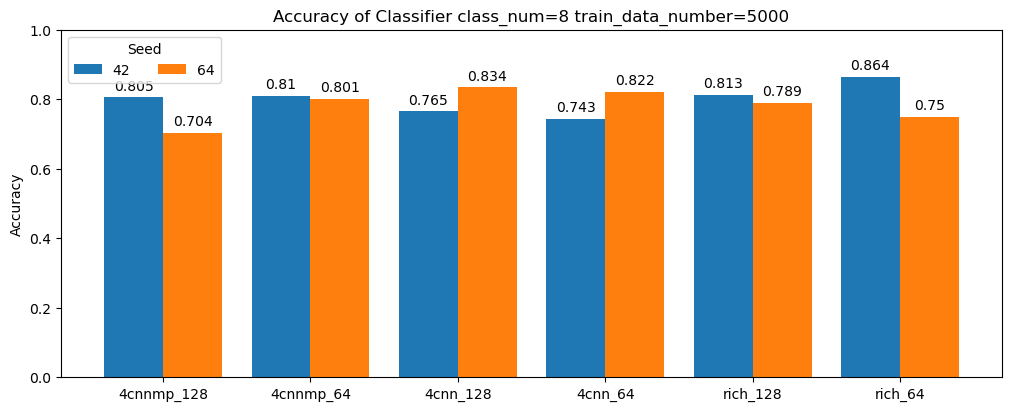

In [79]:
if args.eval_mode:
    fig, ax = plt.subplots(layout='constrained', figsize=(10, 4))
    
    x = np.arange(len(model_name_list))  # the label locations
    width = 0.4  # the width of the bars
    multiplier = 0
    
    for attribute, measurement in random_save_dict.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, list(map(lambda x:round(x, 3), measurement)), width, label=attribute, align="edge")
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy of Classifier class_num={args.class_num} train_data_number={args.train_limit_data}')
    ax.set_xticks(x + width, model_name_list)
    ax.legend(loc='upper left', ncols=3, title="Seed")
    ax.set_ylim(0, 1)

In [37]:
if args.eval_mode:
    checkpoint_path = "/nfs/ksdata/tran/HAR_AE/lightning_logs/10.3_classify_8classes_10000data/version_4/checkpoints/sample_epoch=19639-step=78560-val_loss=0.385121.ckpt"
    
    net = Classifier1D.load_from_checkpoint(checkpoint_path)
    print(net)

Classifier1D(
  (cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Conv1d(32, 64, kernel_size=(8,), stride=(3,))
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=1664, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=8, bias=True)
  )
)

In [80]:
if args.eval_mode:
    classifier_name = "rich_128"
    net = Classifier1DMaxPoolBNModel(
        **channel_param_dict[classifier_name],
        out_class_num = 8,
    )
    print(f"Classifier: {classifier_name}")
    print(net)

Classifier: rich_128
Classifier1DMaxPoolBNModel(
  (cnn): Sequential(
    (0): Conv1d(6, 32, kernel_size=(8,), stride=(3,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(32, 64, kernel_size=(8,), stride=(3,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (linear): Sequential(
    (0): Linear(in_features=1664, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=8, bias=True)
  )
)
